In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit.ML.Descriptors import MoleculeDescriptors

# Import โมเดลและเครื่องมือจาก scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Path ไปยังไฟล์ข้อมูล (ใช้ '../' เพื่อถอยกลับไป 1 ชั้น)
data_path = '../data/train.csv'

# โหลดข้อมูล
try:
    df_raw = pd.read_csv(data_path)
    print(f"Data loaded successfully: {df_raw.shape[0]} rows, {df_raw.shape[1]} columns")
    
    # แสดงตัวอย่าง 5 แถวแรก
    display(df_raw.head())
    
except FileNotFoundError:
    print(f"Error: File not found at {data_path}")
    print("Please ensure 'train.csv' is in the 'data/' folder.")

Data loaded successfully: 2662 rows, 427 columns


,id,SMILES,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,...,Group 415,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424
0,2175,FC1=C(F)C(F)(F)C1(F)F,213.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1222,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2994,CCN1C(C)=Nc2ccccc12,324.15,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1704,CC#CC(=O)O,351.15,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2526,CCCCC(S)C,126.15,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# 1. สร้างคอลัมน์ 'mol' (RDKit molecule object)
df_raw['mol'] = df_raw['SMILES'].apply(lambda smiles: Chem.MolFromSmiles(smiles))

# 2. สร้างฟีเจอร์พื้นฐานที่เราคุยกัน (Physics-Informed)
df_raw['mol_weight'] = df_raw['mol'].apply(Descriptors.MolWt)
df_raw['num_h_donors'] = df_raw['mol'].apply(Descriptors.NumHDonors)
df_raw['num_h_acceptors'] = df_raw['mol'].apply(Descriptors.NumHAcceptors)
df_raw['tpsa'] = df_raw['mol'].apply(Descriptors.TPSA) # Total Polar Surface Area
df_raw['num_rotatable_bonds'] = df_raw['mol'].apply(Descriptors.NumRotatableBonds)
df_raw['mol_logp'] = df_raw['mol'].apply(Descriptors.MolLogP) # Polarity
df_raw['LabuteASA'] = df_raw['mol'].apply(Descriptors.LabuteASA)
df_raw['PolarSurfaceRatio'] = df_raw['tpsa'] / df_raw['LabuteASA']

# 3. แสดงผล DataFrame ใหม่ที่มีฟีเจอร์เพิ่มเข้ามา
print("New features calculated:")
# กรองคอลัมน์ Group 1 - Group 424 ออกก่อนแสดงผล
cols_to_show = [c for c in df_raw.columns if not c.startswith('Group')]
display(df_raw[cols_to_show].head())

New features calculated:


,id,SMILES,Tm,mol,mol_weight,num_h_donors,num_h_acceptors,tpsa,num_rotatable_bonds,mol_logp,LabuteASA,PolarSurfaceRatio
0,2175,FC1=C(F)C(F)(F)C1(F)F,213.15,<rdkit.Chem.rdchem.Mol object at 0x17da591c0>,162.032,0,0,0.00,0,2.42120,51.131856,0.000000
1,1222,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,<rdkit.Chem.rdchem.Mol object at 0x17da59380>,217.271,1,0,15.79,0,4.47430,98.685557,0.160003
2,2994,CCN1C(C)=Nc2ccccc12,324.15,<rdkit.Chem.rdchem.Mol object at 0x17da593f0>,160.220,0,2,17.82,1,2.36462,71.846674,0.248028
3,1704,CC#CC(=O)O,351.15,<rdkit.Chem.rdchem.Mol object at 0x17da59460>,84.074,1,1,37.30,0,0.09430,35.789059,1.042218
4,2526,CCCCC(S)C,126.15,<rdkit.Chem.rdchem.Mol object at 0x17da594d0>,118.245,1,1,0.00,3,2.49490,51.719028,0.000000


In [4]:
# ตรวจสอบว่ามีแถวไหนที่ 'mol' แปลงไม่สำเร็จ (เป็น None)
missing_mols = df_raw['mol'].isnull().sum()
print(f"Number of rows where SMILES failed to parse: {missing_mols}")

# เราจะลบแถวที่แปลงค่าไม่ได้ทิ้งไปเลย
# (inplace=True คือการแก้ไข DataFrame เดิมโดยตรง)
df_clean = df_raw.dropna(subset=['mol']).copy()

# ตรวจสอบข้อมูล 'melting_point' ด้วยว่ามีค่าว่าง (NaN) หรือไม่
missing_mp = df_clean['Tm'].isnull().sum()
print(f"Number of rows with missing Tm: {missing_mp}")
# (ถ้ามีค่าว่าง ก็ลบทิ้งเช่นกัน)
df_clean.dropna(subset=['Tm'], inplace=True)

print(f"Cleaned data shape: {df_clean.shape}")

Number of rows where SMILES failed to parse: 0
Number of rows with missing Tm: 0
Cleaned data shape: (2662, 436)


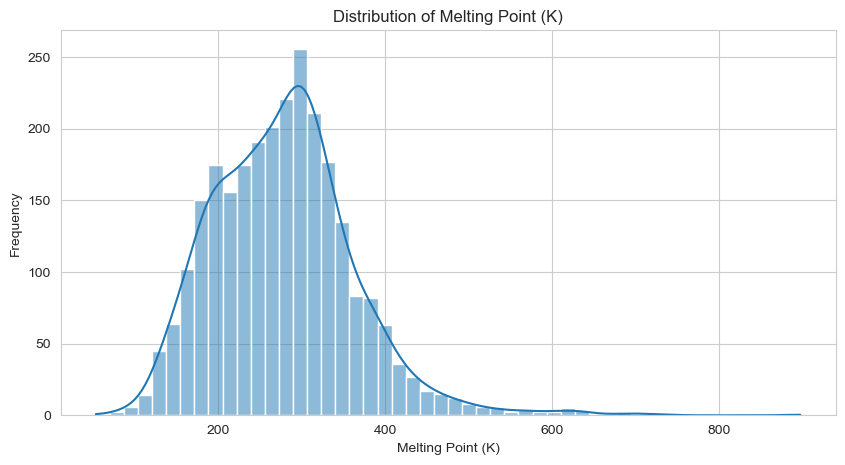

count    2662.000000
mean      278.263452
std        85.117914
min        53.540000
25%       217.000000
50%       277.300000
75%       325.150000
max       897.150000
Name: Tm, dtype: float64

In [16]:
# ตั้งค่าสไตล์ของกราฟ
sns.set_style("whitegrid")

plt.figure(figsize=(10, 5))
sns.histplot(df_clean['Tm'], kde=True, bins=50)
plt.title('Distribution of Melting Point (K)')
plt.xlabel('Melting Point (K)')
plt.ylabel('Frequency')
plt.show()

# ดูค่าสถิติพื้นฐาน
display(df_clean['Tm'].describe())

In [13]:
# ดึงข้อมูลสารที่มีจุดหลอมเหลวสูงกว่า 600 องศาออกมาดู
high_tm = df_clean[df_clean['Tm'] > 600][['SMILES', 'Tm']]
print(high_tm.sort_values(by='Tm', ascending=False))

                                                 SMILES      Tm
1095  CCCCCCCCCCCCCCCC(=O)OCC(COC(=O)CCCCCCCCCCCCCCC...  897.15
1405      CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C  732.15
418              c1cc2ccc3ccc4ccc5ccc6ccc1c7c2c3c4c5c67  710.45
131          CC(C)CCCC(C)CCCC(C)CCCCC(C)CCCC(C)CCCC(C)C  693.15
2526                        CCCCCCCCCCCCCCCCCCCCCC(=O)O  693.15
1361                          CCCCCCCCCCCCCCCCCCCC(=O)O  673.00
744                  c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc34  641.15
445                          CCCCCC=CCC=CCCCCCCCC(=O)OC  639.00
902                           CCCCCC=CCC=CCCCCCCCC(=O)O  638.35
461                              CCCCCCCCCCCCCCCCC(=O)O  635.15
1179                           CCCCCCCCCCCCCCCCCC(=O)OC  625.00
1727                          CCCCCCCCC=CCCCCCCCC(=O)OC  622.00
824                               CCCCCCCCCCCCCCCC(=O)O  612.15
2069                                                ClN  611.15
293                              CCCCCCC

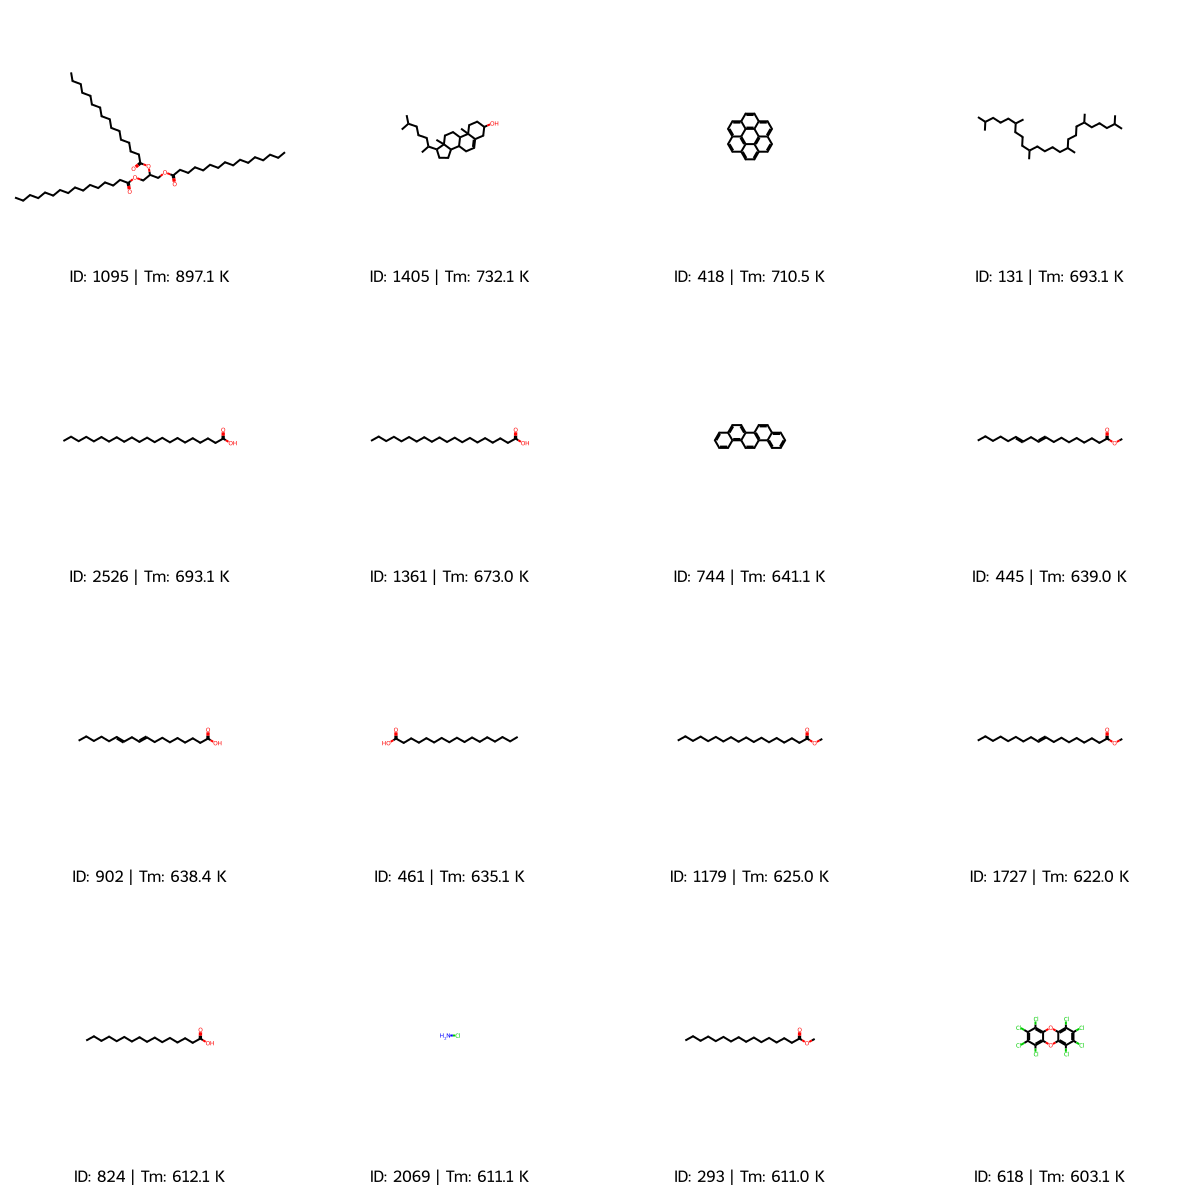

In [15]:
from rdkit.Chem import Draw

# สมมติว่า df คือ DataFrame ของคุณที่มีคอลัมน์ 'SMILES' และ 'Tm'

# --- ฟังก์ชันสำหรับวาดภาพโมเลกุลจาก DataFrame ---
def visualize_molecules(dataframe, num_mols=16):
    mols = []
    legends = []
    
    for index, row in dataframe.head(num_mols).iterrows():
        smiles = row['SMILES']
        tm_val = row['Tm']
        
        # 1. แปลง SMILES เป็น RDKit Mol Object
        mol = Chem.MolFromSmiles(smiles)
        
        if mol:
            mols.append(mol)
            # ใส่ชื่อใต้ภาพเป็นค่า Tm เพื่อดูเทียบกัน
            legends.append(f"ID: {index} | Tm: {tm_val:.1f} K")

    # 2. วาดภาพเป็นตาราง (Grid)
    img = Draw.MolsToGridImage(
        mols, 
        molsPerRow=4, 
        subImgSize=(300, 300), 
        legends=legends
    )
    return img

# --- ลองเรียกใช้งานกับกลุ่มที่เราสงสัย (High Tm) ---

# ดึงข้อมูลที่มี Tm สูงกว่า 600 K และเรียงจากมากไปน้อย
suspects = high_tm.sort_values(by='Tm', ascending=False)

# แสดงภาพ
img = visualize_molecules(suspects)
display(img) # ถ้าใช้ Jupyter Notebook

In [19]:
def clean_messy_data(df):
    """
    ฟังก์ชันสำหรับทำความสะอาดข้อมูล Melting Point
    โดยตัดเกลือและข้อมูลที่ขัดแย้งกับหลักฟิสิกส์ออก
    """
    
    # Copy ข้อมูลมาเพื่อไม่ให้กระทบตารางเดิม
    df_clean = df.copy()
    print(f"จำนวนข้อมูลก่อน Clean: {len(df_clean)} แถว")

    # --- กฎข้อที่ 1: ตัดเกลือ (Salts) ---
    # ถ้า SMILES มีจุด '.' แปลว่ามีหลายส่วนประกอบ (เช่น Na+ กับ Cl-)
    df_clean = df_clean[~df_clean['SMILES'].str.contains('\.')]
    print(f"เหลือหลังจากตัดเกลือ: {len(df_clean)} แถว")

    # --- กฎข้อที่ 2: ตัดข้อมูลขัดแย้งทางฟิสิกส์ (Physics Violation) ---
    # เราต้องใช้ RDKit เพื่อนับจำนวนวงแหวน Aromatic
    
    def is_physically_valid(row):
        smiles = row['SMILES']
        tm = row['Tm']
        
        mol = Chem.MolFromSmiles(smiles)
        if mol is None: return False # เผื่อแปลง SMILES ไม่ได้
        
        # นับจำนวนวงแหวนอะโรมาติก
        num_aromatic = Descriptors.NumAromaticRings(mol)
        
        # LOGIC: ถ้า Tm สูงเกิน 500 K (ประมาณ 227 C) 
        # แต่ไม่มีวงแหวนอะโรมาติกเลย (เป็น 0) -> ถือว่าเป็นข้อมูลขยะ (เช่น ไขมันโซ่ยาวที่ค่าผิด)
        if tm > 500 and num_aromatic == 0:
            return False  # ตัดทิ้ง
        
        return True # เก็บไว้

    # ใช้ .apply เพื่อกรองข้อมูลตาม Logic ข้างบน
    mask = df_clean.apply(is_physically_valid, axis=1)
    df_clean = df_clean[mask]
    
    print(f"จำนวนข้อมูลที่เหลือ (Final): {len(df_clean)} แถว")
    return df_clean

# --- เรียกใช้งาน ---
# สมมติว่าตารางของคุณชื่อ df
df_clean = clean_messy_data(df_clean)

# ลองเช็คดูว่าพวกตัวปัญหาหายไปหรือยัง
print("\nเช็ค 5 อันดับแรกที่ค่าสูงสุดตอนนี้:")
print(df_clean.sort_values(by='Tm', ascending=False)[['SMILES', 'Tm']].head())

จำนวนข้อมูลก่อน Clean: 2662 แถว
เหลือหลังจากตัดเกลือ: 2662 แถว
จำนวนข้อมูลที่เหลือ (Final): 2638 แถว

เช็ค 5 อันดับแรกที่ค่าสูงสุดตอนนี้:
                                                 SMILES      Tm
418              c1cc2ccc3ccc4ccc5ccc6ccc1c7c2c3c4c5c67  710.45
744                  c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc34  641.15
618    Clc1c(Cl)c(Cl)c2Oc3c(Cl)c(Cl)c(Cl)c(Cl)c3Oc2c1Cl  603.15
1566  Brc1c(Br)c(Br)c(Oc2c(Br)c(Br)c(Br)c(Br)c2Br)c(...  568.15
2528            c1ccc(cc1)C(c2ccccc2)(c3ccccc3)c4ccccc4  555.15


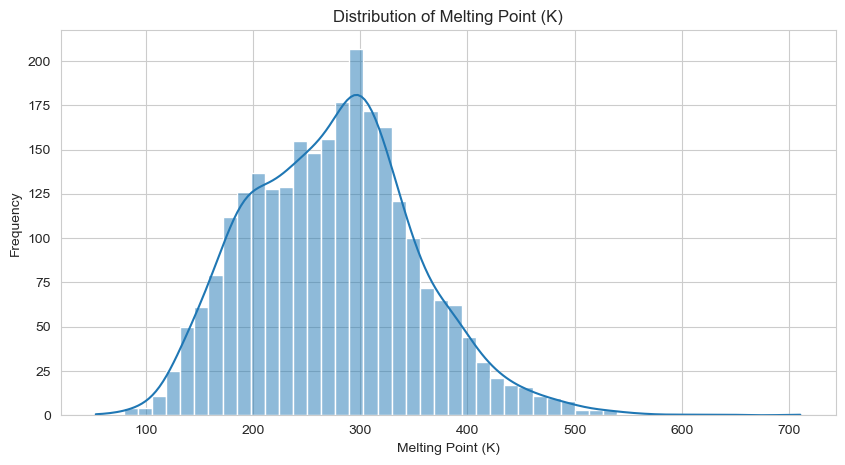

count    2638.000000
mean      275.187854
std        78.745559
min        53.540000
25%       216.150000
50%       275.650000
75%       324.150000
max       710.450000
Name: Tm, dtype: float64

In [20]:
# ตั้งค่าสไตล์ของกราฟ
sns.set_style("whitegrid")

plt.figure(figsize=(10, 5))
sns.histplot(df_clean['Tm'], kde=True, bins=50)
plt.title('Distribution of Melting Point (K)')
plt.xlabel('Melting Point (K)')
plt.ylabel('Frequency')
plt.show()

# ดูค่าสถิติพื้นฐาน
display(df_clean['Tm'].describe())

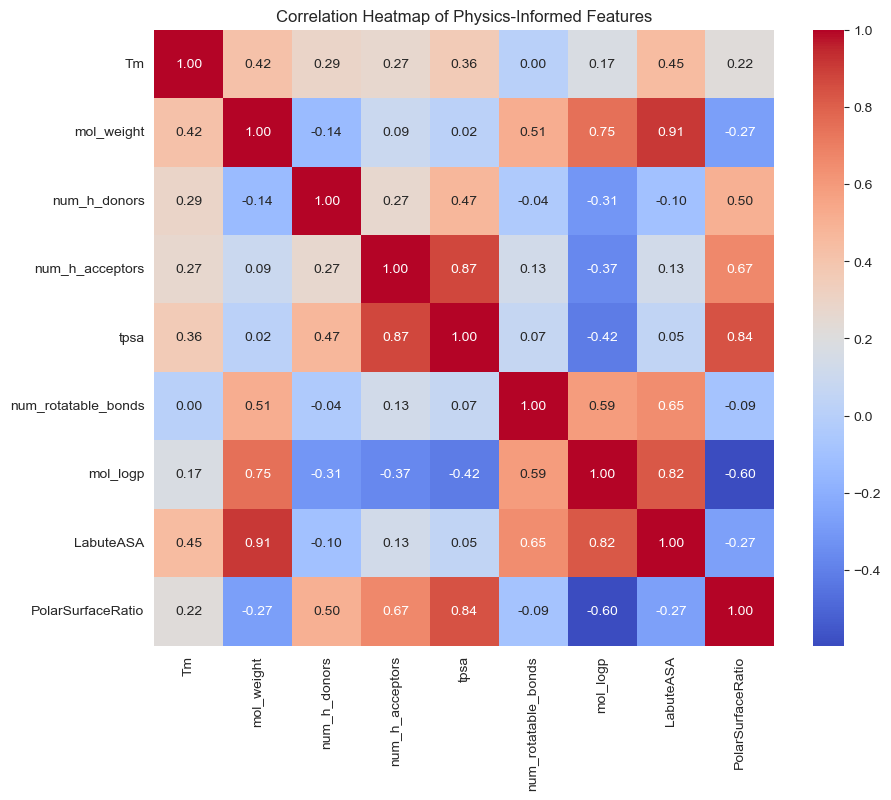

In [21]:
# เลือกเฉพาะคอลัมน์ที่เป็นตัวเลข (ฟีเจอร์) และเป้าหมาย
features_to_correlate = [
    'Tm', 
    'mol_weight', 
    'num_h_donors', 
    'num_h_acceptors', 
    'tpsa', 
    'num_rotatable_bonds',
    'mol_logp',
    'LabuteASA',
    'PolarSurfaceRatio'
]

# คำนวณ Correlation Matrix
corr_matrix = df_clean[features_to_correlate].corr()

# วาด Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Physics-Informed Features')
plt.show()

In [22]:
# 1. กำหนด X (ฟีเจอร์) และ y (เป้าหมาย)
feature_names = [
    'mol_weight', 
    'num_h_donors', 
    'num_h_acceptors', 
    'tpsa', 
    'num_rotatable_bonds',
    'mol_logp',
    'LabuteASA',
    'PolarSurfaceRatio'
]

X = df_clean[feature_names]
y = df_clean['Tm']

# 2. แบ่งข้อมูล (80% Train, 20% Test)
# random_state=42 คือการ "ล็อก" ผลการสุ่ม เพื่อให้ได้ผลลัพธ์เหมือนเดิมทุกครั้งที่รัน
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# 3. สเกลข้อมูล (Scaling) - (สำคัญมากสำหรับ Linear Regression/Lasso)
# เราจะ "ปรับ" ให้ฟีเจอร์ทุกตัวมีค่าเฉลี่ย=0 และ ส่วนเบี่ยงเบน=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# แปลงกลับเป็น DataFrame เพื่อให้อ่านง่าย
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

Training data shape: (2110, 8)
Testing data shape: (528, 8)


=== Lasso Regression Performance ===
Root Mean Squared Error (RMSE): 51.78 K
R-squared (R²): 0.564


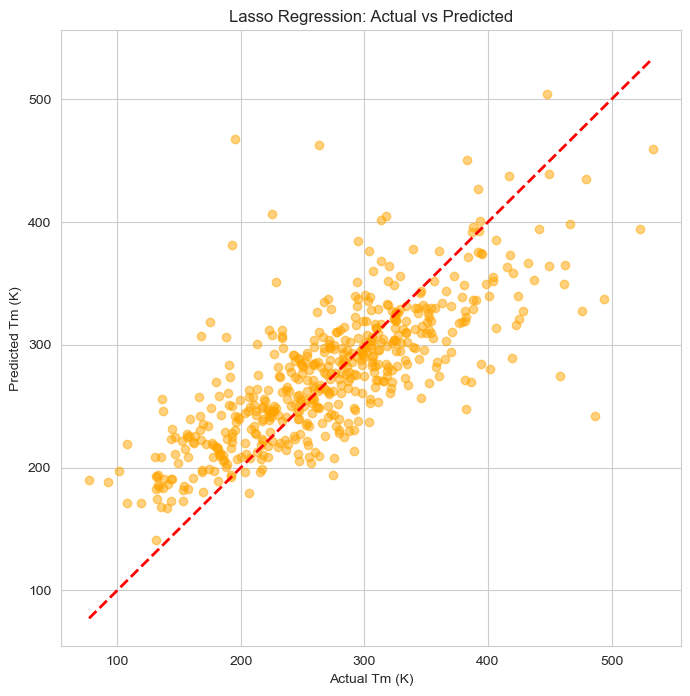


สมการของโมเดล (Coefficients):
LabuteASA              66.852295
PolarSurfaceRatio      19.786204
num_h_donors           15.524299
tpsa                    4.822006
num_h_acceptors        -3.298412
num_rotatable_bonds   -39.800097
dtype: float64


In [31]:
# --- 1. สร้างและเทรนโมเดล Lasso ---
# alpha = ค่าความเข้มงวด (ยิ่งเยอะ ยิ่งตัดฟีเจอร์โหด)
# เราใช้ alpha=1.0 ซึ่งเป็นค่ามาตรฐาน
lasso_final = Lasso(alpha=1.0, random_state=42)
lasso_final.fit(X_train_scaled, y_train)

# --- 2. ทำนายผลบน Test Set ---
y_pred_lasso = lasso_final.predict(X_test_scaled)

# --- 3. ประเมินผล ---
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

print("=== Lasso Regression Performance ===")
print(f"Root Mean Squared Error (RMSE): {rmse_lasso:.2f} K")
print(f"R-squared (R²): {r2_lasso:.3f}")

# --- 4. (แถม) พลอตกราฟเทียบค่าจริง vs ค่าทำนาย ---
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_lasso, alpha=0.5, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # เส้นสมบูรณ์แบบ
plt.xlabel('Actual Tm (K)')
plt.ylabel('Predicted Tm (K)')
plt.title('Lasso Regression: Actual vs Predicted')
plt.show()

# --- 5. ดูว่า Lasso ใช้อะไรคำนวณบ้าง (Equation) ---
print("\nสมการของโมเดล (Coefficients):")
coeffs = pd.Series(lasso_final.coef_, index=feature_names)
print(coeffs[coeffs != 0].sort_values(ascending=False))

In [32]:
def extract_lasso_equation(model, scaler, feature_names):
    # 1. ดึงค่า Scaled Coefficients และ Intercept จากโมเดล
    scaled_coefs = model.coef_
    scaled_intercept = model.intercept_
    
    # 2. ดึงค่า Mean และ Scale (SD) จาก Scaler
    means = scaler.mean_
    scales = scaler.scale_ # นี่คือ SD
    
    # 3. คำนวณ "สัมประสิทธิ์จริง" (Real Coefficients)
    # สูตร: Real_Coef = Scaled_Coef / SD
    real_coefs = scaled_coefs / scales
    
    # 4. คำนวณ "จุดตัดแกนจริง" (Real Intercept)
    # สูตร: Real_Intercept = Scaled_Intercept - Sum(Real_Coef * Mean)
    real_intercept = scaled_intercept - np.sum(real_coefs * means)
    
    # 5. สร้าง DataFrame สรุปผล
    equation_df = pd.DataFrame({
        'Feature': feature_names,
        'Real_Coefficient': real_coefs,
        'Scaled_Coefficient': scaled_coefs # เก็บไว้ดูเทียบ
    })
    
    # กรองเอาเฉพาะตัวที่ไม่เป็น 0
    final_equation = equation_df[equation_df['Scaled_Coefficient'] != 0].copy()
    
    return final_equation, real_intercept

# --- ใช้งาน ---
# ใส่ model lasso ตัวล่าสุด และ scaler ตัวที่คุณใช้เทรน
eqn_df, intercept_val = extract_lasso_equation(lasso_final, scaler, feature_names)

print("=== สมการทำนายจุดหลอมเหลว (Tm) ===")
print(f"Tm (K) = {intercept_val:.4f}")
for index, row in eqn_df.iterrows():
    sign = "+" if row['Real_Coefficient'] > 0 else ""
    print(f"         {sign} ({row['Real_Coefficient']:.4f} * {row['Feature']})")

print("\n--- ตารางค่าสัมประสิทธิ์จริง (เอาไปใส่ Excel) ---")
print(eqn_df[['Feature', 'Real_Coefficient']])

=== สมการทำนายจุดหลอมเหลว (Tm) ===
Tm (K) = 107.7355
         + (25.7897 * num_h_donors)
          (-2.8222 * num_h_acceptors)
         + (0.2446 * tpsa)
          (-11.0493 * num_rotatable_bonds)
         + (2.5556 * LabuteASA)
         + (52.4576 * PolarSurfaceRatio)

--- ตารางค่าสัมประสิทธิ์จริง (เอาไปใส่ Excel) ---
               Feature  Real_Coefficient
1         num_h_donors         25.789748
2      num_h_acceptors         -2.822176
3                 tpsa          0.244645
4  num_rotatable_bonds        -11.049300
6            LabuteASA          2.555593
7    PolarSurfaceRatio         52.457553


In [23]:
# เทรนโมเดล Lasso (ใช้ข้อมูลที่สเกลแล้ว)
lasso_model = Lasso(alpha=1.0) # alpha คือความ "เข้มงวด" ในการคัดฟีเจอร์
lasso_model.fit(X_train_scaled, y_train)

# ดูสัมประสิทธิ์ (Coefficients) ที่โมเดลเลือก
lasso_coeffs = pd.Series(lasso_model.coef_, index=feature_names)
print("Lasso Model Coefficients:")
print(lasso_coeffs.sort_values(ascending=False))

Lasso Model Coefficients:
LabuteASA              66.852295
PolarSurfaceRatio      19.786204
num_h_donors           15.524299
tpsa                    4.822006
mol_weight              0.000000
mol_logp               -0.000000
num_h_acceptors        -3.298412
num_rotatable_bonds   -39.800097
dtype: float64


In [33]:
# 1. ดึงรายชื่อฟีเจอร์ที่ Lasso "เลือก" (ค่า Coefficient ไม่เป็น 0)
# lasso_coeffs ที่คุณสร้างไว้ก่อนหน้าคือ Pandas Series อยู่แล้ว ใช้ง่ายเลย
selected_features = lasso_coeffs[lasso_coeffs != 0].index.tolist()

print(f"Lasso เลือกมา {len(selected_features)} ฟีเจอร์: {selected_features}")
print(f"ฟีเจอร์ที่โดนเท: {lasso_coeffs[lasso_coeffs == 0].index.tolist()}")

# 2. สร้าง X_train และ X_test ชุดใหม่ ที่มีเฉพาะฟีเจอร์ที่ถูกเลือก
# หมายเหตุ: ต้องใช้ DataFrame นะครับถึงจะเลือกด้วยชื่อ column ได้ 
# (ในภาพ X_train_scaled ของคุณเป็น DataFrame แล้วจากบรรทัดท้ายสุดของภาพก่อนหน้า)
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

# 3. เทรน Random Forest ด้วยข้อมูลชุดใหม่ (ที่ผ่านการคัดกรองแล้ว)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_selected, y_train) # <-- ใช้ _selected แทน

# 4. ทำนายผล
y_pred_rf = rf_model.predict(X_test_selected) # <-- ใช้ _selected แทน

# ประเมินผล
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

print("\n--- Random Forest Performance ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} K")
print(f"R-squared (R²): {r2:.3f}")

Lasso เลือกมา 6 ฟีเจอร์: ['num_h_donors', 'num_h_acceptors', 'tpsa', 'num_rotatable_bonds', 'LabuteASA', 'PolarSurfaceRatio']
ฟีเจอร์ที่โดนเท: ['mol_weight', 'mol_logp']

--- Random Forest Performance ---
Root Mean Squared Error (RMSE): 49.15 K
R-squared (R²): 0.607


/var/folders/c3/q6m99mw90d54s778zv_w7fkh0000gn/T/ipykernel_18523/1817837859.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importances.values, y=rf_importances.index, palette='viridis')


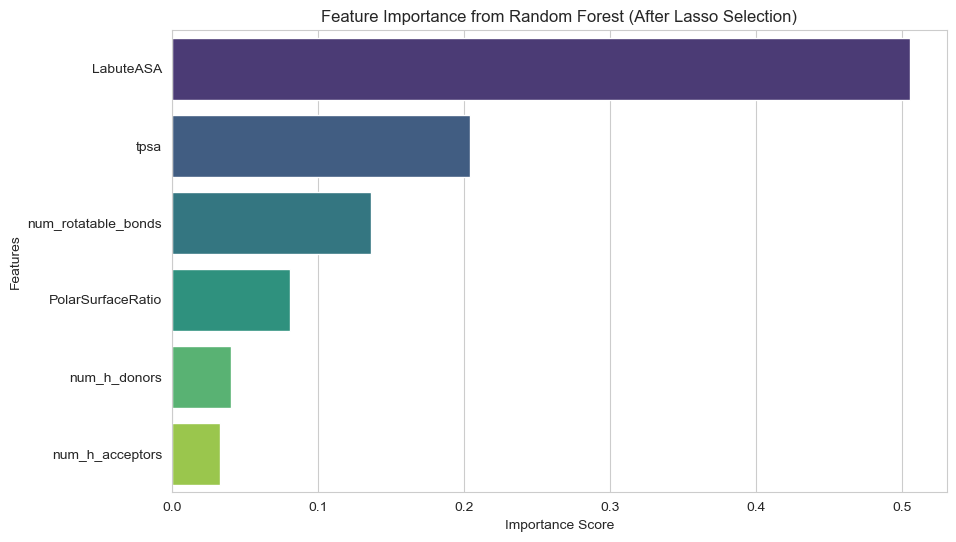

In [28]:
# ดึงค่าความสำคัญจาก Random Forest
rf_importances = pd.Series(rf_model.feature_importances_, index=selected_features)

# เรียงลำดับจากมากไปน้อย
rf_importances = rf_importances.sort_values(ascending=False)

# พลอตกราฟ
plt.figure(figsize=(10, 6))
sns.barplot(x=rf_importances.values, y=rf_importances.index, palette='viridis')
plt.title('Feature Importance from Random Forest (After Lasso Selection)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [34]:
# เทรนโมเดล Random Forest
# n_jobs=-1 คือการบอกให้ใช้ CPU ทุก Core ที่มี (ช่วยให้ M2 ของคุณทำงานเร็วขึ้น)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# ทำนายผลบน Test set
y_pred_rf = rf_model.predict(X_test_scaled)

# ประเมินผล
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

print("\n--- Random Forest Performance ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} K")
print(f"R-squared (R²): {r2:.3f}")


--- Random Forest Performance ---
Root Mean Squared Error (RMSE): 46.50 K
R-squared (R²): 0.648


/var/folders/c3/q6m99mw90d54s778zv_w7fkh0000gn/T/ipykernel_18523/1103485201.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_df.values, y=feature_importance_df.index, palette="viridis")


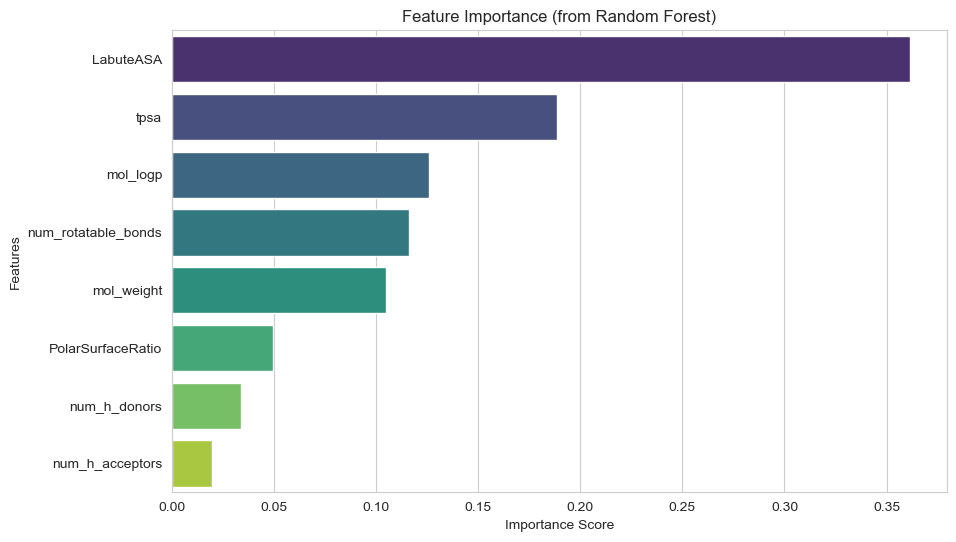

In [25]:
# ดึงค่า Feature Importance จากโมเดล Random Forest
importances = rf_model.feature_importances_
feature_importance_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# พล็อตกราฟ
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_df.values, y=feature_importance_df.index, palette="viridis")
plt.title('Feature Importance (from Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [41]:
# เปรียบเทียบ Tm = MW + LabuteASA + Rotatable_Bonds
# 1. เตรียมข้อมูล SMILES ของ Pentane Isomers
data = [
    {'Name': 'n-Pentane (Straight)', 'SMILES': 'CCCCC', 'Actual_Tm': -129.8},
    {'Name': 'Isopentane (Branched)', 'SMILES': 'CC(C)CC', 'Actual_Tm': -159.9},
    {'Name': 'Neopentane (Spherical)', 'SMILES': 'CC(C)(C)C', 'Actual_Tm': -16.6}
]

results = []

for item in data:
    mol = Chem.MolFromSmiles(item['SMILES'])
    
    # คำนวณค่า
    mw = Descriptors.MolWt(mol)
    asa = Descriptors.LabuteASA(mol) # พื้นที่ผิวโดยประมาณ
    
    results.append({
        'Name': item['Name'],
        'SMILES': item['SMILES'],
        'MW': mw,
        'LabuteASA': asa,
        'Actual_Tm (C)': item['Actual_Tm']
    })

# แสดงผล
df_isomers = pd.DataFrame(results)
print(df_isomers[['Name', 'MW', 'LabuteASA', 'Actual_Tm (C)']])

                     Name      MW  LabuteASA  Actual_Tm (C)
0    n-Pentane (Straight)  72.151  34.199019         -129.8
1   Isopentane (Branched)  72.151  34.199019         -159.9
2  Neopentane (Spherical)  72.151  34.199019          -16.6


In [38]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors

# ข้อมูลสาร 3 ตัวเหมือนเดิม
data = [
    {'Name': 'n-Pentane (Straight)', 'SMILES': 'CCCCC', 'Actual_Tm': -129.8},
    {'Name': 'Isopentane (Branched)', 'SMILES': 'CC(C)CC', 'Actual_Tm': -159.9},
    {'Name': 'Neopentane (Spherical)', 'SMILES': 'CC(C)(C)C', 'Actual_Tm': -16.6}
]

results = []

print("กำลังคำนวณ 3D Conformer เพื่อหา shape... (อาจใช้เวลาแป๊บนึง)")

for item in data:
    mol = Chem.MolFromSmiles(item['SMILES'])
    # เติมไฮโดรเจนเพื่อให้การคำนวณ 3D แม่นยำขึ้น
    mol = Chem.AddHs(mol)
    
    # 1. สร้างโครงสร้าง 3 มิติ (Embedding)
    AllChem.EmbedMolecule(mol, randomSeed=42)
    
    # --- คำนวณ Symmetry 1: Topological (นับจำนวนอะตอมที่ไม่ซ้ำกัน) ---
    # ยิ่งเลขน้อย แปลว่ามีอะตอมหน้าตาเหมือนกันเยอะ = สมมาตรสูง
    # เราจะนับเฉพาะ Heavy Atoms (คาร์บอน) เพื่อความง่าย
    mol_no_h = Chem.RemoveHs(mol)
    unique_atoms = len(set(Chem.CanonicalRankAtoms(mol_no_h, breakTies=False)))
    
    # --- คำนวณ Symmetry 2: 3D Shape (NPR1) ---
    # NPR1 (Normalized Principal Moments Ratio 1)
    # ค่าเข้าใกล้ 0 = รูปร่างยาว (Rod-like)
    # ค่าเข้าใกล้ 1 = รูปร่างกลม/แบนสมมาตร (Sphere/Disc-like)
    npr1 = rdMolDescriptors.CalcNPR1(mol)
    
    # คำนวณค่าเดิม
    mw = Descriptors.MolWt(mol)
    asa = Descriptors.LabuteASA(mol)

    results.append({
        'Name': item['Name'],
        'SMILES': item['SMILES'],
        'LabuteASA (Surface)': asa,
        'Unique_Atoms (Low is Symm)': unique_atoms, # ยิ่งน้อย ยิ่งสมมาตร
        'NPR1 (High is Round)': npr1,               # ยิ่งมาก ยิ่งกลม
        'Actual_Tm (C)': item['Actual_Tm']
    })

df_symm = pd.DataFrame(results)
# เรียงลำดับตามจุดหลอมเหลว เพื่อดูแนวโน้ม
print(df_symm[['Name', 'LabuteASA (Surface)', 'Unique_Atoms (Low is Symm)', 'NPR1 (High is Round)', 'Actual_Tm (C)']].sort_values(by='Actual_Tm (C)', ascending=False))

กำลังคำนวณ 3D Conformer เพื่อหา shape... (อาจใช้เวลาแป๊บนึง)
                     Name  LabuteASA (Surface)  Unique_Atoms (Low is Symm)  \
2  Neopentane (Spherical)            51.058665                           2   
0    n-Pentane (Straight)            51.058665                           3   
1   Isopentane (Branched)            51.058665                           4   

   NPR1 (High is Round)  Actual_Tm (C)  
2              0.941928          -16.6  
0              0.189562         -129.8  
1              0.356719         -159.9  


In [46]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, rdFreeSASA

def get_real_3d_psa_properties(smiles):
    """
    คำนวณค่า 3D-PSA (Polar Surface Area แบบ 3 มิติของจริง)
    และ 3D Polar Ratio
    """
    try:
        # 1. สร้างโมเลกุลและเติม H
        mol = Chem.MolFromSmiles(smiles)
        if mol is None: return None, None, None
        mol = Chem.AddHs(mol)
        
        # 2. สร้างโครงสร้าง 3D (Embedding)
        res = AllChem.EmbedMolecule(mol, randomSeed=42)
        if res == -1: 
            res = AllChem.EmbedMolecule(mol, randomSeed=42, useRandomCoords=True)
            if res == -1: return None, None, None

        # 3. คำนวณ SASA (Total Surface)
        # สำคัญ: คำสั่งนี้จะแอบฝังค่า 'SASA' ไว้ใน property ของแต่ละอะตอมด้วย!
        radii = rdFreeSASA.classifyAtoms(mol)
        total_sasa = rdFreeSASA.CalcSASA(mol, radii)
        
        # 4. ไล่รวมพื้นที่ผิวเฉพาะ "อะตอมที่มีขั้ว" (Polar Atoms)
        polar_3d_area = 0.0
        polar_atomic_nums = {7, 8, 15, 16} # N, O, P, S
        
        for atom in mol.GetAtoms():
            # ดึงค่า SASA ของอะตอมนี้ออกมา
            atom_area = atom.GetDoubleProp("SASA")
            
            is_polar = False
            # เงื่อนไข 1: เป็น N, O, P, S
            if atom.GetAtomicNum() in polar_atomic_nums:
                is_polar = True
            # เงื่อนไข 2: เป็น H ที่เกาะกับ N, O, P, S
            elif atom.GetAtomicNum() == 1: # H
                neighbors = atom.GetNeighbors()
                if neighbors and neighbors[0].GetAtomicNum() in polar_atomic_nums:
                    is_polar = True
            
            if is_polar:
                polar_3d_area += atom_area

        # 5. คำนวณ Ratio (3D PSA / 3D Total SASA)
        # นี่คือ "สัดส่วนความมีขั้ว" ที่แท้จริงในเชิงเรขาคณิต
        polar_ratio_3d = polar_3d_area / total_sasa if total_sasa > 0 else 0.0
        
        return total_sasa, polar_3d_area, polar_ratio_3d

    except Exception as e:
        # print(f"Error: {e}") # เปิด print เพื่อ debug ถ้าต้องการ
        return None, None, None

# --- ทดสอบเปรียบเทียบ ---
data = [
    {'Name': 'n-Pentane (Straight)', 'SMILES': 'CCCCC', 'Actual_Tm': -129.8},
    {'Name': 'Isopentane (Branched)', 'SMILES': 'CC(C)CC', 'Actual_Tm': -159.9},
    {'Name': 'Neopentane (Spherical)', 'SMILES': 'CC(C)(C)C', 'Actual_Tm': -16.6}
]

df_test = pd.DataFrame(data)

print("กำลังคำนวณ Real 3D-PSA...")
df_test[['SASA_Total', 'PSA_3D_Real', 'Polar_Ratio_3D']] = df_test['SMILES'].apply(
    lambda x: pd.Series(get_real_3d_psa_properties(x))
)

print(df_test.round(2))

กำลังคำนวณ Real 3D-PSA...
                     Name     SMILES  Actual_Tm  SASA_Total  PSA_3D_Real  \
0    n-Pentane (Straight)      CCCCC     -129.8      160.35          0.0   
1   Isopentane (Branched)    CC(C)CC     -159.9      163.53          0.0   
2  Neopentane (Spherical)  CC(C)(C)C      -16.6      152.80          0.0   

   Polar_Ratio_3D  
0             0.0  
1             0.0  
2             0.0  


เริ่มใหม่กับ features 3D

In [48]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, rdFreeSASA, rdMolDescriptors

# ฟังก์ชันรวมสำหรับคำนวณ 3D Features ทั้งหมดในรอบเดียว (เพื่อประหยัดเวลา)
def calculate_3d_advanced_features(mol):
    try:
        if mol is None:
            return pd.Series([None]*5)
        
        # 1. เตรียมโมเดล 3D (เติม H + Embed)
        mol_3d = Chem.AddHs(mol)
        res = AllChem.EmbedMolecule(mol_3d, randomSeed=42)
        if res == -1:
            res = AllChem.EmbedMolecule(mol_3d, randomSeed=42, useRandomCoords=True)
            if res == -1: return pd.Series([None]*5) # ถ้าสร้าง 3D ไม่ได้จริงๆ ให้ข้าม

        # --- A. คำนวณ SASA และ Real 3D-PSA ---
        radii = rdFreeSASA.classifyAtoms(mol_3d)
        # คำนวณ SASA และเก็บค่าไว้ใน property ของอะตอม
        total_sasa = rdFreeSASA.CalcSASA(mol_3d, radii)
        
        polar_3d_area = 0.0
        polar_atomic_nums = {7, 8, 15, 16} # N, O, P, S
        
        for atom in mol_3d.GetAtoms():
            is_polar = False
            if atom.GetAtomicNum() in polar_atomic_nums:
                is_polar = True
            elif atom.GetAtomicNum() == 1: # Hydrogen
                neighbors = atom.GetNeighbors()
                if neighbors and neighbors[0].GetAtomicNum() in polar_atomic_nums:
                    is_polar = True
            
            if is_polar:
                # ดึงค่า SASA เฉพาะของอะตอมนี้
                polar_3d_area += atom.GetDoubleProp("SASA")
        
        polar_ratio_3d = polar_3d_area / total_sasa if total_sasa > 0 else 0.0

        # --- B. คำนวณ Shape & Symmetry ---
        # NPR1 (Normalized Principal Moments Ratio 1) -> ความกลม (1=กลม, 0=ยาว)
        npr1 = rdMolDescriptors.CalcNPR1(mol_3d)
        
        # Unique Atoms (Topological Symmetry) -> ยิ่งน้อย ยิ่งสมมาตร
        # นับจากกราฟปกติ (ไม่เอา H) เพื่อดูความสมมาตรทางโครงสร้างหลัก
        unique_atoms = len(set(Chem.CanonicalRankAtoms(mol, breakTies=False)))

        return pd.Series([total_sasa, polar_3d_area, polar_ratio_3d, unique_atoms, npr1])

    except Exception as e:
        return pd.Series([None]*5)

# ==========================================
# เริ่มต้นกระบวนการ Feature Engineering
# ==========================================

# 1. สร้างคอลัมน์ 'mol'
# แนะนำ: ถ้าข้อมูลเยอะ ให้ทำแค่ครั้งเดียวแล้ว reuse
if 'mol' not in df_raw.columns:
    df_raw['mol'] = df_raw['SMILES'].apply(Chem.MolFromSmiles)

# 2. สร้างฟีเจอร์พื้นฐาน (2D) ที่ยังคงไว้
print("Calculating 2D Descriptors...")
df_raw['mol_weight'] = df_raw['mol'].apply(Descriptors.MolWt)
df_raw['num_h_donors'] = df_raw['mol'].apply(Descriptors.NumHDonors)
df_raw['num_h_acceptors'] = df_raw['mol'].apply(Descriptors.NumHAcceptors)
df_raw['num_rotatable_bonds'] = df_raw['mol'].apply(Descriptors.NumRotatableBonds)
df_raw['mol_logp'] = df_raw['mol'].apply(Descriptors.MolLogP)

# 3. สร้างฟีเจอร์ขั้นสูง (3D) - ส่วนที่แก้ไข
print("Calculating Advanced 3D Descriptors (This may take a while)...")

# สร้างชื่อคอลัมน์ใหม่
new_3d_cols = ['SASA_Total', 'PSA_3D_Real', 'Polar_Ratio_3D', 'unique_atoms', 'npr1']

# Apply ฟังก์ชันเดียว ได้ 5 คอลัมน์รวด
df_raw[new_3d_cols] = df_raw['mol'].apply(calculate_3d_advanced_features)

# 4. จัดการค่าที่คำนวณไม่ได้ (Drop หรือ Fill)
# เนื่องจาก 3D อาจมีบางตัว Fail แนะนำให้ลบแถวที่คำนวณไม่ได้ทิ้ง
df_raw.dropna(subset=new_3d_cols, inplace=True)

# 5. แสดงผล
print("\nFeatures calculated successfully!")
cols_to_show = [
    'SMILES', 'Tm', 
    'mol_weight', 'num_h_donors', 'num_h_acceptors', 'num_rotatable_bonds', 'mol_logp', # 2D เดิม
    'SASA_Total', 'PSA_3D_Real', 'Polar_Ratio_3D', 'unique_atoms', 'npr1' # 3D ใหม่
]

# กรองเอาเฉพาะคอลัมน์ที่มีอยู่จริง (เผื่อ Tm ไม่มีใน Test set)
cols_to_show = [c for c in cols_to_show if c in df_raw.columns]

display(df_raw[cols_to_show].head())

Calculating 2D Descriptors...
Calculating Advanced 3D Descriptors (This may take a while)...


[13:15:53] UFFTYPER: Unrecognized charge state for atom: 1
[13:15:54] UFFTYPER: Unrecognized charge state for atom: 1
[13:15:59] UFFTYPER: Unrecognized charge state for atom: 1
[13:15:59] UFFTYPER: Unrecognized charge state for atom: 2
[13:16:00] UFFTYPER: Unrecognized charge state for atom: 2
[13:16:04] UFFTYPER: Unrecognized charge state for atom: 1



Features calculated successfully!


,SMILES,Tm,mol_weight,num_h_donors,num_h_acceptors,num_rotatable_bonds,mol_logp,SASA_Total,PSA_3D_Real,Polar_Ratio_3D,unique_atoms,npr1
0,FC1=C(F)C(F)(F)C1(F)F,213.15,162.032,0,0,0,2.42120,123.842089,0.000000,0.000000,4.0,0.698429
1,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,217.271,1,0,0,4.47430,254.566097,21.031525,0.082617,17.0,0.255867
2,CCN1C(C)=Nc2ccccc12,324.15,160.220,0,2,1,2.36462,230.249976,17.050439,0.074052,12.0,0.330125
3,CC#CC(=O)O,351.15,84.074,1,1,0,0.09430,119.187459,44.959274,0.377215,6.0,0.135766
4,CCCCC(S)C,126.15,118.245,1,1,3,2.49490,204.474672,29.057149,0.142106,7.0,0.410870


In [49]:
# ตรวจสอบว่ามีแถวไหนที่ 'mol' แปลงไม่สำเร็จ (เป็น None)
missing_mols = df_raw['mol'].isnull().sum()
print(f"Number of rows where SMILES failed to parse: {missing_mols}")

# เราจะลบแถวที่แปลงค่าไม่ได้ทิ้งไปเลย
# (inplace=True คือการแก้ไข DataFrame เดิมโดยตรง)
df_clean = df_raw.dropna(subset=['mol']).copy()

# ตรวจสอบข้อมูล 'melting_point' ด้วยว่ามีค่าว่าง (NaN) หรือไม่
missing_mp = df_clean['Tm'].isnull().sum()
print(f"Number of rows with missing Tm: {missing_mp}")
# (ถ้ามีค่าว่าง ก็ลบทิ้งเช่นกัน)
df_clean.dropna(subset=['Tm'], inplace=True)

print(f"Cleaned data shape: {df_clean.shape}")

Number of rows where SMILES failed to parse: 0
Number of rows with missing Tm: 0
Cleaned data shape: (2662, 441)


In [51]:
def clean_messy_data(df):
    """
    ฟังก์ชันสำหรับทำความสะอาดข้อมูล Melting Point
    โดยตัดเกลือและข้อมูลที่ขัดแย้งกับหลักฟิสิกส์ออก
    """
    
    # Copy ข้อมูลมาเพื่อไม่ให้กระทบตารางเดิม
    df_clean = df.copy()
    print(f"จำนวนข้อมูลก่อน Clean: {len(df_clean)} แถว")

    # --- กฎข้อที่ 1: ตัดเกลือ (Salts) ---
    # ถ้า SMILES มีจุด '.' แปลว่ามีหลายส่วนประกอบ (เช่น Na+ กับ Cl-)
    df_clean = df_clean[~df_clean['SMILES'].str.contains('\.')]
    print(f"เหลือหลังจากตัดเกลือ: {len(df_clean)} แถว")

    # --- กฎข้อที่ 2: ตัดข้อมูลขัดแย้งทางฟิสิกส์ (Physics Violation) ---
    # เราต้องใช้ RDKit เพื่อนับจำนวนวงแหวน Aromatic
    
    def is_physically_valid(row):
        smiles = row['SMILES']
        tm = row['Tm']
        
        mol = Chem.MolFromSmiles(smiles)
        if mol is None: return False # เผื่อแปลง SMILES ไม่ได้
        
        # นับจำนวนวงแหวนอะโรมาติก
        num_aromatic = Descriptors.NumAromaticRings(mol)
        
        # LOGIC: ถ้า Tm สูงเกิน 500 K (ประมาณ 227 C) 
        # แต่ไม่มีวงแหวนอะโรมาติกเลย (เป็น 0) -> ถือว่าเป็นข้อมูลขยะ (เช่น ไขมันโซ่ยาวที่ค่าผิด)
        if tm > 500 and num_aromatic == 0:
            return False  # ตัดทิ้ง
        
        return True # เก็บไว้

    # ใช้ .apply เพื่อกรองข้อมูลตาม Logic ข้างบน
    mask = df_clean.apply(is_physically_valid, axis=1)
    df_clean = df_clean[mask]
    
    print(f"จำนวนข้อมูลที่เหลือ (Final): {len(df_clean)} แถว")
    return df_clean

# --- เรียกใช้งาน ---
# สมมติว่าตารางของคุณชื่อ df
df_clean = clean_messy_data(df_clean)

# ลองเช็คดูว่าพวกตัวปัญหาหายไปหรือยัง
print("\nเช็ค 5 อันดับแรกที่ค่าสูงสุดตอนนี้:")
print(df_clean.sort_values(by='Tm', ascending=False)[['SMILES', 'Tm']].head())

จำนวนข้อมูลก่อน Clean: 2662 แถว
เหลือหลังจากตัดเกลือ: 2662 แถว
จำนวนข้อมูลที่เหลือ (Final): 2638 แถว

เช็ค 5 อันดับแรกที่ค่าสูงสุดตอนนี้:
                                                 SMILES      Tm
418              c1cc2ccc3ccc4ccc5ccc6ccc1c7c2c3c4c5c67  710.45
744                  c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc34  641.15
618    Clc1c(Cl)c(Cl)c2Oc3c(Cl)c(Cl)c(Cl)c(Cl)c3Oc2c1Cl  603.15
1566  Brc1c(Br)c(Br)c(Oc2c(Br)c(Br)c(Br)c(Br)c2Br)c(...  568.15
2528            c1ccc(cc1)C(c2ccccc2)(c3ccccc3)c4ccccc4  555.15


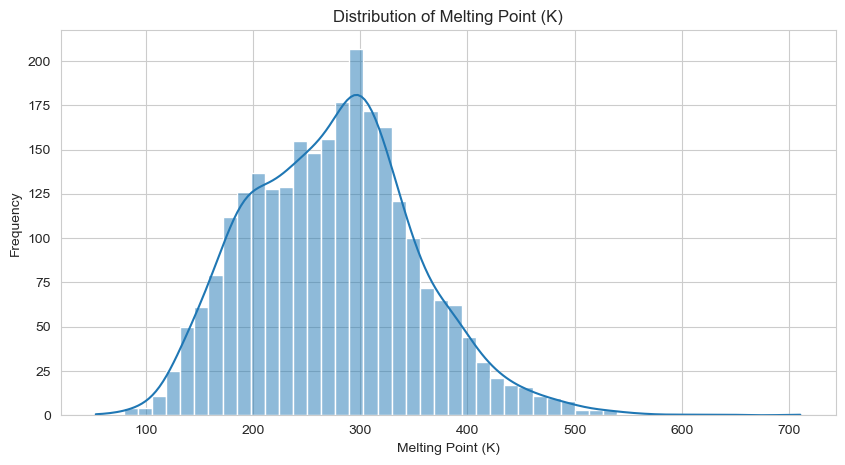

count    2638.000000
mean      275.187854
std        78.745559
min        53.540000
25%       216.150000
50%       275.650000
75%       324.150000
max       710.450000
Name: Tm, dtype: float64

In [52]:
# ตั้งค่าสไตล์ของกราฟ
sns.set_style("whitegrid")

plt.figure(figsize=(10, 5))
sns.histplot(df_clean['Tm'], kde=True, bins=50)
plt.title('Distribution of Melting Point (K)')
plt.xlabel('Melting Point (K)')
plt.ylabel('Frequency')
plt.show()

# ดูค่าสถิติพื้นฐาน
display(df_clean['Tm'].describe())

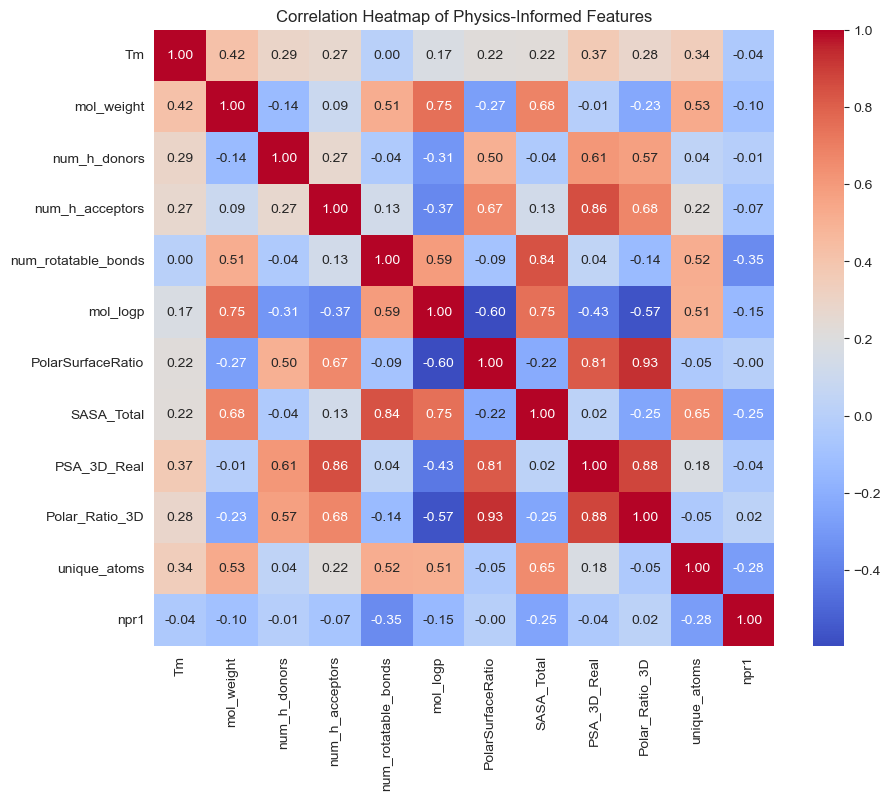

In [54]:
# เลือกเฉพาะคอลัมน์ที่เป็นตัวเลข (ฟีเจอร์) และเป้าหมาย
features_to_correlate = [
    'Tm', 
    'mol_weight', 
    'num_h_donors', 
    'num_h_acceptors',
    'num_rotatable_bonds',
    'mol_logp',
    'PolarSurfaceRatio',
    'SASA_Total',
    'PSA_3D_Real',
    'Polar_Ratio_3D',
    'unique_atoms',
    'npr1'
]

# คำนวณ Correlation Matrix
corr_matrix = df_clean[features_to_correlate].corr()

# วาด Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Physics-Informed Features')
plt.show()

In [55]:
# 1. กำหนด X (ฟีเจอร์) และ y (เป้าหมาย)
feature_names = [
    'mol_weight', 
    'num_h_donors', 
    'num_h_acceptors',
    'num_rotatable_bonds',
    'mol_logp',
    'PolarSurfaceRatio',
    'SASA_Total',
    'PSA_3D_Real',
    'Polar_Ratio_3D',
    'unique_atoms',
    'npr1'
]

X = df_clean[feature_names]
y = df_clean['Tm']

# 2. แบ่งข้อมูล (80% Train, 20% Test)
# random_state=42 คือการ "ล็อก" ผลการสุ่ม เพื่อให้ได้ผลลัพธ์เหมือนเดิมทุกครั้งที่รัน
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# 3. สเกลข้อมูล (Scaling) - (สำคัญมากสำหรับ Linear Regression/Lasso)
# เราจะ "ปรับ" ให้ฟีเจอร์ทุกตัวมีค่าเฉลี่ย=0 และ ส่วนเบี่ยงเบน=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# แปลงกลับเป็น DataFrame เพื่อให้อ่านง่าย
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

Training data shape: (2110, 11)
Testing data shape: (528, 11)


In [57]:
# เทรนโมเดล Lasso (ใช้ข้อมูลที่สเกลแล้ว)
lasso_model = Lasso(alpha=1.0) # alpha คือความ "เข้มงวด" ในการคัดฟีเจอร์
lasso_model.fit(X_train_scaled, y_train)

# ดูสัมประสิทธิ์ (Coefficients) ที่โมเดลเลือก
lasso_coeffs = pd.Series(lasso_model.coef_, index=feature_names)
print("Lasso Model Coefficients:")
print(lasso_coeffs.sort_values(ascending=False))

Lasso Model Coefficients:
mol_weight             35.111928
SASA_Total             24.803900
Polar_Ratio_3D         21.235521
num_h_donors           13.063078
mol_logp                9.203665
unique_atoms            7.985728
PolarSurfaceRatio       5.077751
PSA_3D_Real             0.623226
num_h_acceptors        -0.000000
npr1                   -5.410789
num_rotatable_bonds   -45.521614
dtype: float64


In [58]:
# 1. ดึงรายชื่อฟีเจอร์ที่ Lasso "เลือก" (ค่า Coefficient ไม่เป็น 0)
# lasso_coeffs ที่คุณสร้างไว้ก่อนหน้าคือ Pandas Series อยู่แล้ว ใช้ง่ายเลย
selected_features = lasso_coeffs[lasso_coeffs != 0].index.tolist()

print(f"Lasso เลือกมา {len(selected_features)} ฟีเจอร์: {selected_features}")
print(f"ฟีเจอร์ที่โดนเท: {lasso_coeffs[lasso_coeffs == 0].index.tolist()}")

# 2. สร้าง X_train และ X_test ชุดใหม่ ที่มีเฉพาะฟีเจอร์ที่ถูกเลือก
# หมายเหตุ: ต้องใช้ DataFrame นะครับถึงจะเลือกด้วยชื่อ column ได้ 
# (ในภาพ X_train_scaled ของคุณเป็น DataFrame แล้วจากบรรทัดท้ายสุดของภาพก่อนหน้า)
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

# 3. เทรน Random Forest ด้วยข้อมูลชุดใหม่ (ที่ผ่านการคัดกรองแล้ว)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_selected, y_train) # <-- ใช้ _selected แทน

# 4. ทำนายผล
y_pred_rf = rf_model.predict(X_test_selected) # <-- ใช้ _selected แทน

# ประเมินผล
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

print("\n--- Random Forest Performance ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} K")
print(f"R-squared (R²): {r2:.3f}")

Lasso เลือกมา 10 ฟีเจอร์: ['mol_weight', 'num_h_donors', 'num_rotatable_bonds', 'mol_logp', 'PolarSurfaceRatio', 'SASA_Total', 'PSA_3D_Real', 'Polar_Ratio_3D', 'unique_atoms', 'npr1']
ฟีเจอร์ที่โดนเท: ['num_h_acceptors']

--- Random Forest Performance ---
Root Mean Squared Error (RMSE): 44.31 K
R-squared (R²): 0.681
